<a href="https://colab.research.google.com/github/SofianBRh/Projet-Ia-M1/blob/main/Rag_Projet_MS1IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction au Projet de Génération Augmentée par Récupération (RAG)

### La Génération Augmentée par Récupération (RAG) représente une avancée révolutionnaire dans le domaine du traitement du langage naturel (NLP). Cette approche combine les capacités de génération de texte des modèles de langage avec la récupération d'informations pertinentes à partir de bases de données ou de collections de documents. L'objectif est de produire des réponses plus précises, informées et contextuellement pertinentes en utilisant des données externes, augmentant ainsi considérablement les capacités des modèles de langage.

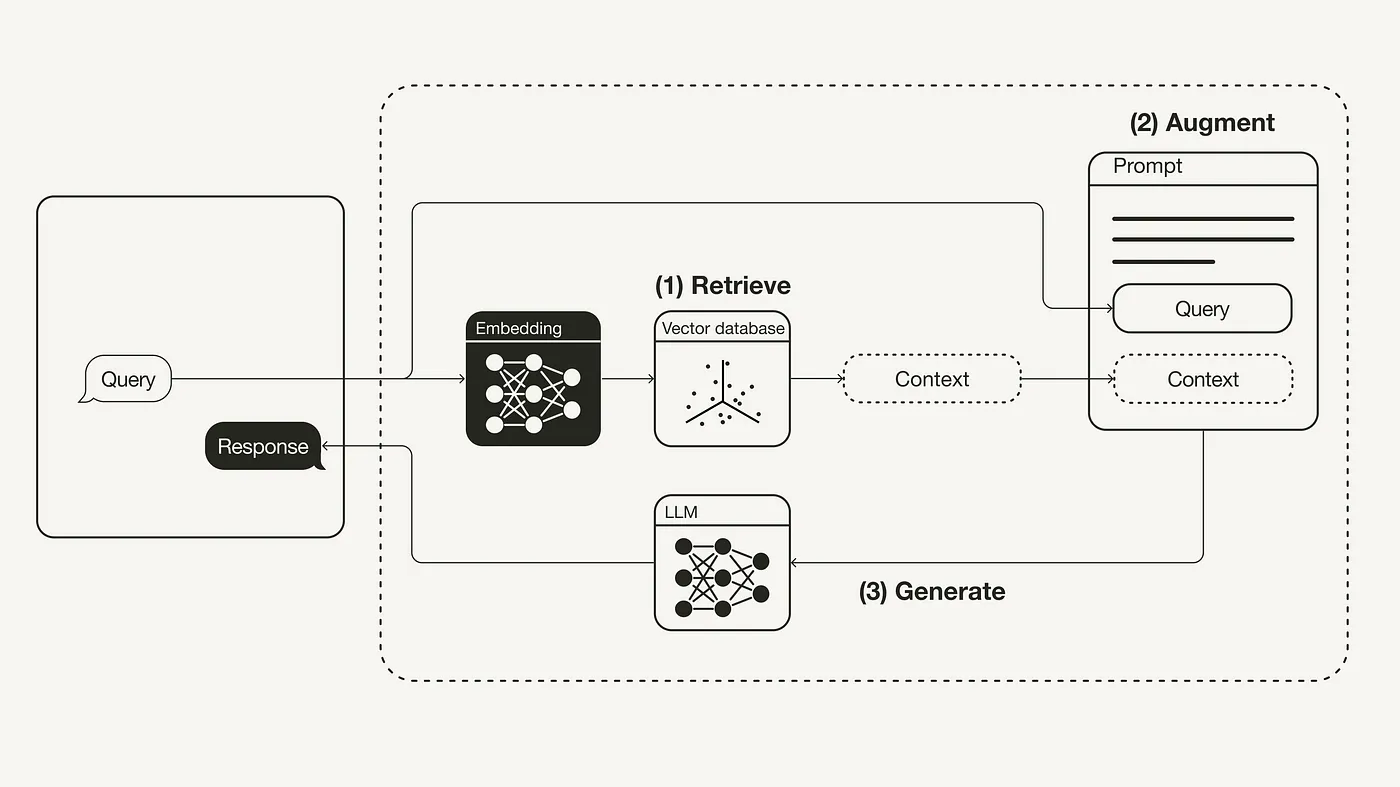
#Contexte et Motivation

## Les modèles de langage traditionnels, comme GPT-3 et ses successeurs, sont entraînés sur de vastes corpus de texte, leur permettant de générer du texte de manière autonome. Cependant, ils peuvent parfois manquer de précision lorsqu'ils traitent des questions nécessitant des informations spécifiques ou à jour. C'est là qu'intervient la RAG, en permettant aux modèles de langage d'accéder à des informations externes spécifiques pour enrichir leurs réponses.
#Objectifs du Projet

##Ce projet vise à mettre en œuvre une pipeline de génération augmentée par récupération en utilisant différents modèles de langage et techniques de récupération. Nous explorerons notamment l'utilisation des modèles GPT-3.5 et Mistral, en combinant leurs capacités avec celles de la base de données ChromaDB pour stocker et récupérer les documents pertinents. L'objectif est de comparer l'efficacité et la pertinence des réponses générées par ces modèles dans différents scénarios.
#Méthodologie

# Préparation des Données :

##Les documents sont chargés depuis un répertoire local et préparés pour être indexés dans ChromaDB. Chaque document est découpé en unités de texte (phrases, paragraphes ou tokens) pour optimiser la récupération.

# Génération des Embeddings :

## Utilisation de modèles d'embedding tels que text-embedding-ada-002 de OpenAI pour GPT et all-MiniLM-L6-v2 de Sentence Transformers pour Mistral. Les embeddings sont des représentations vectorielles des textes, facilitant la recherche de documents pertinents.

# Récupération et Génération :

## Implémentation de fonctions pour récupérer les documents les plus pertinents en fonction du prompt de l'utilisateur, puis génération de réponses en utilisant les modèles de langage. Cette approche permet de contextualiser les réponses avec des informations spécifiques provenant des documents récupérés.

# Cas d'Usage

## Le projet sera testé sur des cas pratiques tels que la génération de résumés, la réponse à des questions spécifiques sur des sujets techniques ou académiques, et la comparaison de la pertinence des réponses fournies par différents modèles. Par exemple, nous examinerons les contributions de Paul Graham aux startups en récupérant et en utilisant des passages pertinents de ses essais pour générer des réponses complètes et précises.

In [ ]:
!pip install openai  chromadb
!pip install chromadb feedparser html2text unidecode regex htmldate
!pip install requests
!pip install sentence-transformers

# Pensez a mettre vos clée API

In [ ]:
# Définir la clé API OpenAI comme variable d'environnement
from google.colab import userdata
import os

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ["REPLICATE_API_TOKEN"] = userdata.get('REPLICATE_API_TOKEN')

# Ici on telecharge des essai pour ensuite embellir notre base de donné vectorielle .

In [ ]:
# Step 2: Import necessary modules
import os
import feedparser
import urllib.request
import time
import html2text
import unidecode
import regex as re
from htmldate import find_date
import csv
import torch


# Setup
rss = feedparser.parse("http://www.aaronsw.com/2002/feeds/pgessays.rss")
h = html2text.HTML2Text()
h.ignore_images = True
h.ignore_tables = True
h.escape_all = True
h.reference_links = True
h.mark_code = True

ART_NO = 1
FILE = "./essays.csv"
if ART_NO == 1:
    if os.path.isfile(FILE):
        os.remove(FILE)

os.makedirs('./essays', exist_ok=True)

for entry in reversed(rss.entries):
    URL = entry["link"]
    if "http://www.paulgraham.com/https://" in URL:
        URL = URL.replace("http://www.paulgraham.com/https://", "https://")
    TITLE = entry["title"]

    try:
        with urllib.request.urlopen(URL) as website:
            content = website.read().decode("utf-8")
            parsed = h.handle(content)
            title = "_".join(TITLE.split(" ")).lower()
            title = re.sub(r"[\W\s]+", "", title)
            with open(f"./essays/{ART_NO:03}_{title}.md", "wb+") as file:
                file.write(f"# {ART_NO:03} {TITLE}\n\n".encode())
                file.write(parsed.encode())

                with open(FILE, "a+", newline="\n") as f:
                    csvwriter = csv.writer(f, quoting=csv.QUOTE_MINIMAL, delimiter=",", quotechar='"')
                    if ART_NO == 1:
                        fieldnames = ["Article no.", "Title", "Date", "URL"]
                        csvwriter = csv.DictWriter(f, fieldnames=fieldnames)
                        csvwriter.writeheader()

                    DATE = find_date(URL)
                    line = [ART_NO, TITLE, DATE, URL]
                    csvwriter.writerow(line)

                print(f"✅ {ART_NO:03} {TITLE}")
    except Exception as e:
        print(f"❌ {ART_NO:03} {entry['title']}, ({e})")
    ART_NO += 1


# Utilisation de Chroma pour créer trois collections distinctes

## Le but est de déterminer comment découper notre texte pour se rapprocher au maximum du langage utilisé par le modèle. Pour une meilleure concordance et un résultat plus pertinent, nous utilisons également SentenceTransformer pour créer des embeddings, qui sont des vecteurs générés à partir de notre texte.

## Concrètement, le prompt est transformé en vecteur d'embedding, puis nous interrogeons notre base de données pour récupérer des éléments correspondant à nos vecteurs.

In [ ]:
import os
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings

# Initialize the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

def get_embedding(text):
    return model.encode(text).tolist()

def load_documents_from_directory_sentence(directory_path):
    documents = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".md"):
            with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
                text = file.read()
                sentences = text.split('. ')
                for sentence in sentences:
                    documents.append({"text": sentence, "metadata": {"source": filename}})
    return documents

def load_documents_from_directory_token(directory_path, max_tokens_per_chunk=500):
    documents = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".md"):
            with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
                text = file.read()
                words = text.split()
                chunks = [' '.join(words[i:i + max_tokens_per_chunk]) for i in range(0, len(words), max_tokens_per_chunk)]
                for chunk in chunks:
                    documents.append({"text": chunk, "metadata": {"source": filename}})
    return documents

def load_documents_from_directory_paragraph(directory_path):
    documents = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".md"):
            with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
                text = file.read()
                paragraphs = text.split('\n\n')
                for paragraph in paragraphs:
                    documents.append({"text": paragraph, "metadata": {"source": filename}})
    return documents

# Set up Chroma
client = chromadb.Client(Settings())

def create_collection(collection_name, documents):
    if collection_name not in [col.name for col in client.list_collections()]:
        client.create_collection(name=collection_name)
    collection = client.get_collection(name=collection_name)
    for doc in documents:
        embedding = get_embedding(doc['text'])
        collection.add(documents=[doc['text']], embeddings=[embedding], metadatas=[doc['metadata']], ids=[doc['metadata']['source']])
    return collection

# Load documents and create collections
directory_path = "./essays"
sentence_docs = load_documents_from_directory_sentence(directory_path)
token_docs = load_documents_from_directory_token(directory_path)
paragraph_docs = load_documents_from_directory_paragraph(directory_path)

create_collection("essays_sentence", sentence_docs)
create_collection("essays_token", token_docs)
create_collection("essays_paragraph", paragraph_docs)


# Ici, nous testons notre solution via OpenAI.

# Ce script montre comment configurer une pipeline de génération augmentée par récupération (RAG) en utilisant GPT-3.5-turbo d'OpenAI pour générer des réponses basées sur un contexte récupéré à partir d'une collection de documents stockés dans ChromaDB.
## Installation des dépendances

## Pour exécuter ce script dans Google Colab, assurez-vous d'installer les bibliothèques nécessaires :



 Configuration et Initialisation

  Configuration de la clé API OpenAI :

 Le script configure la clé API OpenAI pour authentifier les requêtes vers l'API OpenAI. Remplacez l'espace réservé par votre véritable clé API OpenAI.

python

    import os
    import openai
    import chromadb
    from chromadb.config import Settings

    api_key = "votre_cle_openai"
    os.environ['OPENAI_API_KEY'] = api_key
    openai.api_key = api_key

  Initialisation du client ChromaDB :
  
  Le script initialise un client ChromaDB pour gérer et interroger les collections de documents.

python

    client = chromadb.Client(Settings())

    Fonctions
    get_embedding(text)

  But :
  
  Obtenir des embeddings pour un texte donné en utilisant le modèle text-embedding-ada-002 d'OpenAI.

  Implémentation :
  
  Appelle l'API OpenAI pour créer des embeddings pour le texte d'entrée et retourne le vecteur d'embedding.



    def get_embedding(text):
    response = openai.Embedding.create(
        input=[text],
        model="text-embedding-ada-002"
    )
    return response['data'][0]['embedding']

    rag_provider(prompt, context, collection, max_tokens=8192)

  But :
  
  Générer une réponse à un prompt donné en récupérant des documents pertinents depuis une collection ChromaDB et en utilisant le modèle GPT-3.5-turbo d'OpenAI pour générer la réponse.

  Implémentation :

  Récupère des documents pertinents basés sur le prompt.
        Prépare les messages pour le modèle de chat.
        Appelle l'API OpenAI pour générer une complétion basée sur le prompt et les documents récupérés.
        Calcule l'utilisation des tokens et le coût de l'appel à l'API.


    def rag_provider(prompt, context, collection, max_tokens=8192):
    query_embedding = get_embedding(prompt)
    results = collection.query(query_embeddings=[query_embedding], n_results=5)

    messages = [{"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}]
    for result in results['documents'][0]:
        messages.append({"role": "assistant", "content": result})

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    output = response['choices'][0]['message']['content']

    prompt_tokens = len(prompt.split())
    completion_tokens = len(output.split())
    total_tokens = prompt_tokens + completion_tokens

    price_per_1k_tokens = 0.002
    cost = (total_tokens / 1000) * price_per_1k_tokens

    return {
        "output": output,
        "tokenUsage": {
            "total": total_tokens,
            "prompt": prompt_tokens,
            "completion": completion_tokens,
            "cost": cost,
        },
        "cached": False,
    }

Exemple d'utilisation pour une collection de phrases

    Initialisation de la collection :
        Assurez-vous que la collection de documents est créée dans ChromaDB.
        Pour cet exemple, nous supposons que le nom de la collection est "essays_sentence".

python

    collection_name = "essays_sentence"
    prompt = "Parle de l'essai 34 de Paul Graham et fais un résumé."
    context = {}

    collection = client.get_collection(name=collection_name)
    response = rag_provider(prompt, context, collection)
    print(f"Résultats pour la collection {collection_name} :")
    print(response)

Exécution du Script
Assurez-vous d'avoir installé les bibliothèques nécessaires (openai, chromadb, etc.).

Remplacez la clé API par votre véritable clé API OpenAI.
Assurez-vous que la collection de documents est correctement configurée dans ChromaDB.
Exécutez le script pour voir les résultats.

In [ ]:
import os
import openai
import chromadb
from chromadb.config import Settings


# Set up the OpenAI API key
api_key = "YOUR API KEY "
os.environ['OPENAI_API_KEY'] = api_key
openai.api_key = api_key

def get_embedding(text):
    response = openai.Embedding.create(
        input=[text],
        model="text-embedding-ada-002"
    )
    return response['data'][0]['embedding']

# Set up Chroma
client = chromadb.Client(Settings())

def rag_provider(prompt, context, collection, max_tokens=8192):
    # Retrieve relevant documents
    query_embedding = get_embedding(prompt)
    results = collection.query(query_embeddings=[query_embedding], n_results=5)

    # Prepare the messages for the chat model
    messages = [{"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}]
    for result in results['documents'][0]:
        messages.append({"role": "assistant", "content": result})

    # Call the OpenAI chat model
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    output = response['choices'][0]['message']['content']

    prompt_tokens = len(prompt.split())
    completion_tokens = len(output.split())
    total_tokens = prompt_tokens + completion_tokens

    # Calculate cost
    price_per_1k_tokens = 0.002
    cost = (total_tokens / 1000) * price_per_1k_tokens

    return {
        "output": output,
        "tokenUsage": {
            "total": total_tokens,
            "prompt": prompt_tokens,
            "completion": completion_tokens,
            "cost": cost,
        },
        "cached": False,
    }

# Example usage for sentence collection
collection_name = "essays_sentence"
prompt = "Talk about Paul Graham's essay 34 and make a resume."
context = {}

collection = client.get_collection(name=collection_name)
response = rag_provider(prompt, context, collection)
print(f"Results for {collection_name} collection:")
print(response)


# Ici, nous testons notre solution sur Mistral afin de comparer la pertinence des deux réponses.
## Contrairement a gpt qui a son propre embending ici nous devos untiliser un model tierce qui nour permet de faire la meme chose

# Différences de Modèles d'Embedding

#  text-embedding-ada-002 (utilisé dans le script précédent) :

##  Modèle fourni par OpenAI, optimisé pour générer des embeddings de haute qualité pour une variété de tâches NLP.
##        Intégré de manière transparente avec les API OpenAI pour une utilisation simplifiée.

#  all-MiniLM-L6-v2 (utilisé dans ce script) :

##  Modèle de Sentence Transformers, compact et rapide, idéal pour les tâches nécessitant des embeddings de phrases.
##  Peut être utilisé localement sans nécessiter une API externe, offrant ainsi plus de contrôle sur le processus de génération des embeddings.

In [ ]:
import os
import requests
import json
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings

# Endpoint for text completions
MISTRAL_COMPLETION_URL = "https://mixtral-8x22b-instruct-v01.s"

# Initialize the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

def mistral_request(prompt, api_url):
    headers = {
        "Content-Type": "application/json",
    }
    data = {
        "prompt": prompt,
        "max_tokens": 150,
        "temperature": 0.1,
        "top_p": 1.0
    }
    response = requests.post(api_url, headers=headers, data=json.dumps(data))
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Request failed with status code {response.status_code}: {response.text}")

def get_embedding(text):
    return model.encode(text).tolist()

def load_documents_from_directory(directory_path, max_tokens_per_doc=1000):
    documents = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".md"):
            with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
                text = file.read()
                tokens = len(text.split())
                if tokens > max_tokens_per_doc:
                    text = ' '.join(text.split()[:max_tokens_per_doc])
                documents.append({"text": text, "metadata": {"source": filename}})
    return documents

# Set up Chroma
client = chromadb.Client(Settings())

# Create a sentence collection
collection_name = "essays_sentence"
if collection_name not in [col.name for col in client.list_collections()]:
    client.create_collection(name=collection_name)
    documents = load_documents_from_directory("./essays")
    for doc in documents:
        embedding = get_embedding(doc['text'])
        collection.add(documents=[doc['text']], embeddings=[embedding], metadatas=[doc['metadata']], ids=[doc['metadata']['source']])

collection = client.get_collection(name=collection_name)

# Load documents and add to the collection

def rag_provider(prompt, context, collection, max_tokens=8192):
    query_embedding = get_embedding(prompt)
    results = collection.query(query_embeddings=[query_embedding], n_results=5)
    retrieved_texts = " ".join([doc[0] for doc in results['documents']])
    combined_prompt = f"{prompt}Context from documents:\n{retrieved_texts}"

    headers = {
        'Content-Type': 'application/json',
    }
    data = {
        "prompt": combined_prompt,
        "max_tokens": max_tokens
    }
    response = requests.post(MISTRAL_COMPLETION_URL, headers=headers, data=json.dumps(data))
    print
    output = response.json()
    print(output)
    output = output['choices'][0]['text']

    prompt_tokens = len(prompt.split())
    completion_tokens = len(output.split())
    total_tokens = prompt_tokens + completion_tokens

    return {
        "output": output,
        "tokenUsage": {
            "total": total_tokens,
            "prompt": prompt_tokens,
            "completion": completion_tokens,
        },
        "cached": False,
    }

# Example usage
prompt = "Talk about Paul Graham's essay 34 and make a resume."
context = {}
response = rag_provider(prompt, context, collection)
print(f"Results for {collection_name} collection:")
print(response)


# Seconde Partie
Nous installons node Js pour ensuite pouvoir utilisé pormptfoo , promptfoo est un outils qui nous permet d'evalué nos reponse et de les comparée.
https://www.promptfoo.dev/


In [ ]:
!curl -sL https://deb.nodesource.com/setup_18.x | sudo -E bash -
!sudo apt-get install -y nodejs

In [ ]:
# Step 1: Set the npm configuration to automatically say 'yes'
import os
os.environ['npm_config_yes'] = 'true'

# Step 2: Run the promptfoo initialization command
!npx promptfoo@latest init


Configuration de PromptFoo - Guide Readme

Ce guide explique comment configurer et utiliser PromptFoo
Fichier promptfooconfig.yaml

Le fichier promptfooconfig.yaml contient la configuration principale de PromptFoo, permettant de définir les prompts, les modèles d'IA disponibles, et les tests pour évaluer la génération de texte.
Structure du fichier YAML :

yaml

# Configuration de PromptFoo pour Google Colab

prompts: ["/content/prompts.txt"]


    Prompts :
        Description : Spécifie le chemin d'accès au fichier prompts.txt contenant les prompts que PromptFoo utilisera pour générer du texte.
        Exemple : prompts: ["/content/prompts.txt"]

    Providers :
        Description : Liste des modèles d'IA disponibles pour la génération de texte, incluant les modèles intégrés d'OpenAI et les scripts Python externes.
        Exemple :

        yaml

    providers:
      - openai:chat:gpt-4-0613
      - openai:chat:gpt-3.5-turbo-0613
      - openai:chat:gpt-3.5-turbo-0301
      - exec:python rag_mistral_sentence.py
      - exec:python rag_gpt_sentence.py

    Tests :

    Description : Définit des tests spécifiques pour évaluer la performance de PromptFoo en générant du texte en réponse à des questions prédéfinies.
    Exemple :

    yaml

        tests:
          - vars:
              name: Bob
              question: What are some of Paul Graham's thoughts on technology trends?
            config:
              temperature: 0.3
              max_tokens: 150
              expected_output: "Expected output for main themes."
              assert:
                - type: contains
                  value: "technology"
                - type: contains
                  value: "trends"

          - vars:
              name: Jane
              question: Summarize the key points of Paul Graham's essays.
            config:
              temperature: 0.5
              max_tokens: 200
              expected_output: "Expected summary of key points."
              assert:
                - type: contains
                  value: "technology"
                - type: contains
                  value: "trends"

Explication des paramètres :

    Prompts :
        Chemin : Spécifie l'emplacement du fichier prompts.txt.

    Providers :
        Modèles OpenAI : openai:chat:gpt-4-0613, openai:chat:gpt-3.5-turbo-0613, openai:chat:gpt-3.5-turbo-0301 : Modèles d'IA fournis par OpenAI pour la génération de texte.
        Scripts Python externes : exec:python rag_mistral_sentence.py, exec:python rag_gpt_sentence.py : Scripts Python externes qui enrichissent les capacités de génération de texte de PromptFoo.

    Tests :
        Variables (vars) :
            name : Nom de la personne posant la question.
            question : Question ou instruction pour la génération de texte.
        Configuration (config) :
            temperature : Contrôle la créativité du texte généré.
            max_tokens : Limite le nombre maximum de tokens dans la réponse générée.
            expected_output : Réponse attendue pour évaluer la performance.
        Assertions (assert) :
            Vérifie si certains mots-clés ou phrases sont présents dans la réponse générée.

Fichier prompts.txt

Le fichier prompts.txt contient les prompts spécifiques que PromptFoo utilisera pour générer du texte en réponse à des instructions données.
Structure du fichier texte :

    "What is the impact of AI on healthcare?
    Summarize the main findings of the latest climate change report."

  Chaque ligne représente un prompt unique, une question ou une directive spécifique pour la génération de texte par PromptFoo.

In [ ]:
%%writefile prompts.txt
You're an ecommerce chat assistant .
Answer this user's question: {{name}}: "{{question}}"
---
You're a smart, bubbly chat assistant .
Answer this user's question: {{name}}: "{{question}}"

In [ ]:
%%writefile promptfooconfig.yaml
prompts: ["/content/prompts.txt"]
providers:
  - openai:chat:gpt-4-0613
  - openai:chat:gpt-3.5-turbo-0613
  - openai:chat:gpt-3.5-turbo-0301
  - exec:python rag_mistral_sentence.py
  - exec:python rag_gpt_sentence.py

tests:
  - vars:
      name: Bob
      question: What are some of Paul Graham's thoughts on technology trends?
    config:
      temperature: 0.3
      max_tokens: 150
      expected_output: "Expected output for main themes."
      assert:
        - type: contains
          value: "technology"
        - type: contains
          value: "trends"
  - vars:
      name: Jane
      question: Summarize the key points of Paul Graham's essays.
    config:
      temperature: 0.5
      max_tokens: 200
      expected_output: "Expected summary of key points."
      assert:
        - type: contains
          value: "technology"
        - type: contains
          value: "trends"



In [ ]:




with open('/content/rag_mistral_sentence.py', 'w') as file:
    file.write("""
import os
import requests
import json
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings

# Endpoint for text completions
MISTRAL_COMPLETION_URL = "https://mixtral-8x22b-instruct-v01.kepler"

# Initialize the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

def mistral_request(prompt, api_url):
    headers = {
        "Content-Type": "application/json",
    }
    data = {
        "prompt": prompt,
        "max_tokens": 150,
        "temperature": 0.1,
        "top_p": 1.0
    }
    response = requests.post(api_url, headers=headers, data=json.dumps(data))
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Request failed with status code {response.status_code}: {response.text}")

def get_embedding(text):
    return model.encode(text).tolist()

# Set up Chroma
client = chromadb.Client(Settings())

def rag_provider(prompt, context, collection, max_tokens=8192):
    query_embedding = get_embedding(prompt)
    print(query_embedding)
    results = collection.query(query_embeddings=[query_embedding], n_results=5)
    print(results)

    retrieved_texts = " ".join([doc[0] for doc in results['documents']])
    combined_prompt = f'{prompt}Context from documents:{retrieved_texts}'

    headers = {
        'Content-Type': 'application/json',
    }
    data = {
        "prompt": combined_prompt,
        "max_tokens": max_tokens
    }
    response = requests.post(MISTRAL_COMPLETION_URL, headers=headers, data=json.dumps(data))
    output = response.json()['choices'][0]['text']

    prompt_tokens = len(prompt.split())
    completion_tokens = len(output.split())
    total_tokens = prompt_tokens + completion_tokens

    return {
        "output": output,
        "tokenUsage": {
            "total": total_tokens,
            "prompt": prompt_tokens,
            "completion": completion_tokens,
        },
        "cached": False,
    }

# Example usage for sentence collection
collection_name = "essays_sentence"
prompt = "Talk about Paul Graham's essay 34 and make a resume."
context = {}

collection = client.get_collection(name=collection_name)
response = rag_provider(prompt, context, collection)
print(f"Results for {collection_name} collection:")
print(response)

""")


In [ ]:




with open('/content/rag_gpt_sentence.py', 'w') as file:
    file.write("""
import os
import openai
import chromadb
from chromadb.config import Settings


# Set up the OpenAI API key
api_key = "YOUR OPEN AI API KEY "
os.environ['OPENAI_API_KEY'] = api_key
openai.api_key = api_key

def get_embedding(text):
    response = openai.Embedding.create(
        input=[text],
        model="text-embedding-ada-002"
    )
    return response['data'][0]['embedding']

# Set up Chroma
client = chromadb.Client(Settings())

def rag_provider(prompt, context, collection, max_tokens=8192):
    # Retrieve relevant documents
    query_embedding = get_embedding(prompt)
    results = collection.query(query_embeddings=[query_embedding], n_results=5)

    # Prepare the messages for the chat model
    messages = [{"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}]
    for result in results['documents'][0]:
        messages.append({"role": "assistant", "content": result})

    # Call the OpenAI chat model
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    output = response['choices'][0]['message']['content']

    prompt_tokens = len(prompt.split())
    completion_tokens = len(output.split())
    total_tokens = prompt_tokens + completion_tokens

    # Calculate cost
    price_per_1k_tokens = 0.002
    cost = (total_tokens / 1000) * price_per_1k_tokens

    return {
        "output": output,
        "tokenUsage": {
            "total": total_tokens,
            "prompt": prompt_tokens,
            "completion": completion_tokens,
            "cost": cost,
        },
        "cached": False,
    }

# Example usage for sentence collection
collection_name = "essays_sentence"
prompt = "Talk about Paul Graham's essay 34 and make a resume."
context = {}

collection = client.get_collection(name=collection_name)
response = rag_provider(prompt, context, collection)
print(f"Results for {collection_name} collection:")
print(response)




""")


In [ ]:
!npx promptfoo@latest eval -c /content/promptfooconfig.yaml
!npx promptfoo@latest share --yes